In [4]:
## data analysis libraries
import pandas as pd
import numpy as np
## visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
## filtering warnings
import warnings
warnings.filterwarnings("ignore")
## general libraries
import time
import random
import datetime
## statistics libraries
import statistics
from scipy import stats
## model building libraries
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
## ml algorithms
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor, Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.svm import SVR
## Ensemble algorithms
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
## metrics 
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error,median_absolute_error,r2_score

In [5]:
## reading data
data = pd.read_excel("Concrete_Data.xls")
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### Data Dictionary

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

We have 1030 values and 9 variables in our data.

In [7]:
## renaming the columns
data.columns = ['cement_component','furnace_slag','fly_ash',"water_component",'superplasticizer','coarse_agg','fine_agg','age','concrete_strength']
data.head(2)

,cement_component,furnace_slag,fly_ash,water_component,superplasticizer,coarse_agg,fine_agg,age,concrete_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366


## Checking correlation

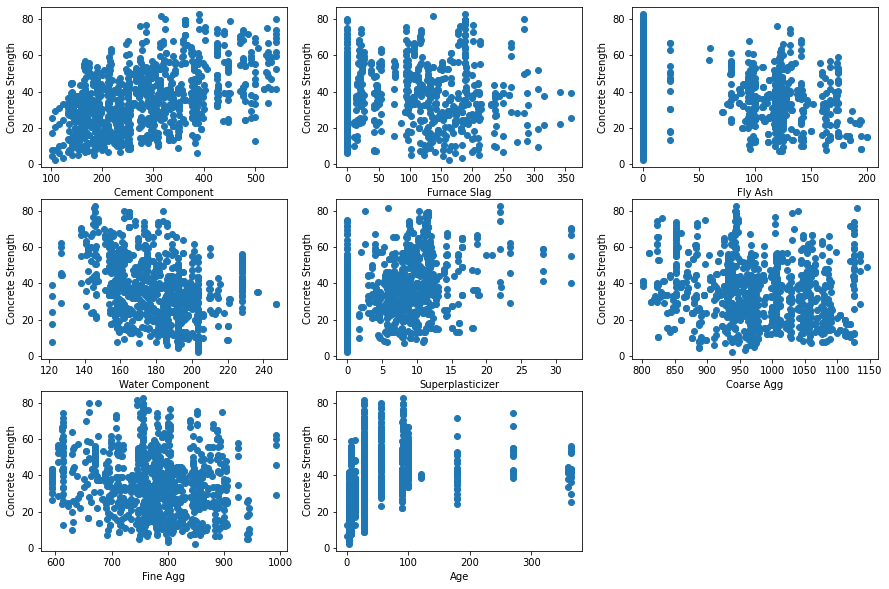

In [8]:
plt.figure(figsize = (15,10))
plot_count = 1

for feature in list(data.columns)[:-1]:
    plt.subplot(3,3,plot_count)
    plt.scatter(data[feature],data['concrete_strength'])
    plt.xlabel(feature.replace("_"," ").title())
    plt.ylabel("Concrete Strength")
    plot_count += 1

plt.show()

- The presence of outliers are negligible in any of these varaibles.
- In some of scatterplots we see that maximum values are lurking on zero. The variables in relationship with concrete strength are Fly ash,Age,Superplasticizer,Furnace Slag
- We can see positive , negative and in some plots negative correlations.

#### Positive correlation exist between
- Concrete Strength and cement component
- Concrete strength and superplasticizer

#### Negative correlation exist  between
- Concrete strength and Water Component
- Concrete strength and fine aggregate
- Concrete strength and Coarse aggregate
- Concrete strength and Fly ash

#### No correlation
- concrete strength and age
- concrete strength and Furnace slag

In [9]:
## finding correlations statistically
print(data.corr(method = 'pearson')['concrete_strength'])

cement_component     0.497833
furnace_slag         0.134824
fly_ash             -0.105753
water_component     -0.289613
superplasticizer     0.366102
coarse_agg          -0.164928
fine_agg            -0.167249
age                  0.328877
concrete_strength    1.000000
Name: concrete_strength, dtype: float64


## Checking Multicollinearity

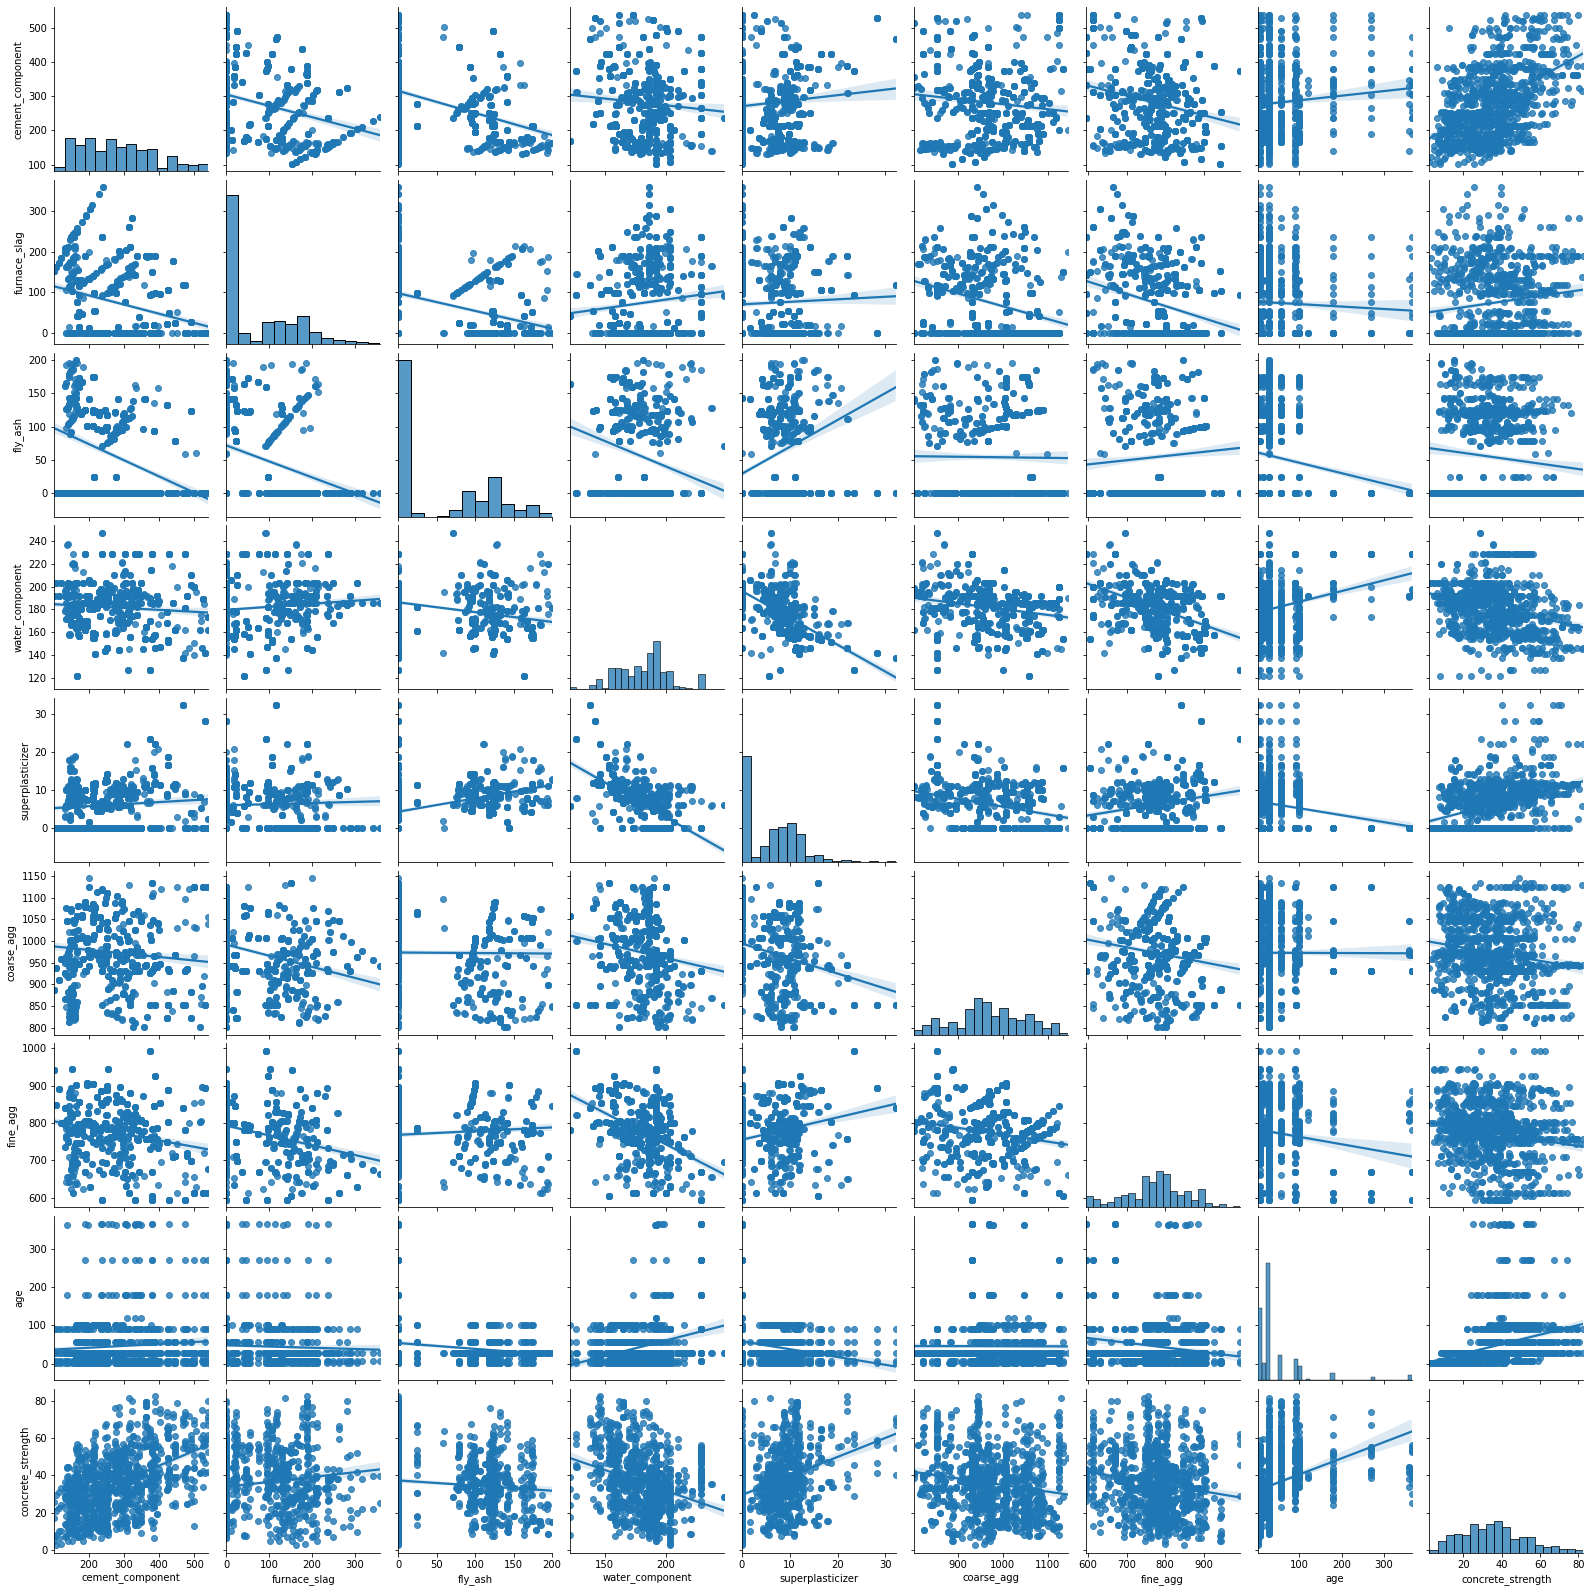

In [10]:
data_ = data[(data.T != 0).any()]
sns.pairplot(data_,vars = data.columns,kind = 'reg')
plt.show()

In many of the cases
feature pairs don’t have a correlation between them. Exception lies in two cases—that is,
cement component and furnace slag and cement component and fly ash—where we can
see a strong negative correlation

## Building the model

In [11]:
def split_train_test(data, feature, train_index=0.7):
    train, test = train_test_split(data, test_size = 1-train_index,random_state = 123)
    if type(feature) == list:
        x_train = train[feature].to_numpy()
        y_train = train['concrete_strength'].to_numpy()
        x_test = test[feature].to_numpy()
        y_test = test['concrete_strength'].to_numpy()
    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]
        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]
    return x_train, y_train, x_test, y_test

## Simple Linear Regression

cement_component       0.24239757657889227
fly_ash       0.07658587994453692
water_component       0.09926973338079692
superplasticizer       0.05732699810729469
coarse_agg       0.010810583900674353


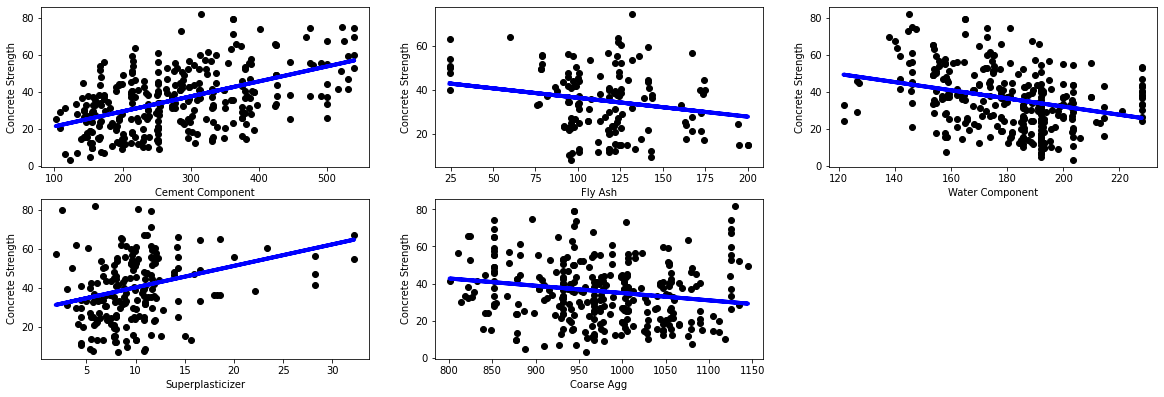

In [12]:
plt.figure(figsize=(20,10))
plot_count = 1

from sklearn.preprocessing import StandardScaler
std = StandardScaler()

for feature in ['cement_component','fly_ash','water_component','superplasticizer','coarse_agg']:
    data_tr = data[['concrete_strength',feature]]
    data_tr = data_tr[(data_tr.T != 0).all()]
    x_train,y_train,x_test,y_test = split_train_test(data_tr,feature)
    
    ## preprocessing the model
    x_train_scaled = std.fit_transform(x_train)
    x_test_scaled = std.transform(x_test)
    ## creating the model
    lr = LinearRegression()
    
    #Train the model using the training sets
    lr.fit(x_train_scaled,y_train)
    y_pred = lr.predict(x_test_scaled)
    
    # plotting outputs
    plt.subplot(3,3,plot_count)
    plt.scatter(x_test , y_test , color = 'black')
    plt.plot(x_test , y_pred, color = 'blue',linewidth = 4)
    plt.xlabel(feature.replace("_"," ").title())
    plt.ylabel("Concrete Strength")
    
    print(feature,"     " ,r2_score(y_test,y_pred))
    plot_count += 1
    
plt.show()

## Multiple Linear Regression

#### Linear regression

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: 0.080054
Intercept: 40.011990
Coefficients: [ 4.27092993 -2.16623978 -1.1613041   1.81687336 -0.41577903]


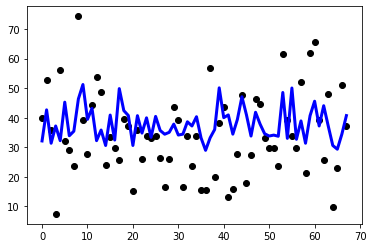

In [45]:
features = ['cement_component','fly_ash','water_component','superplasticizer','coarse_agg']
data_tr = data.copy(deep = True)
data_tr = data_tr[ (data_tr.T!=0).all() ]
x_train,y_train,x_test,y_test = split_train_test(data_tr,features)

x_train_scaled = std.fit_transform(x_train)
x_test_scled = std.transform(x_test)
lr = LinearRegression()
lr.fit(x_train_scaled,y_train)
y_pred = lr.predict(x_test_scled)

plt.scatter(range(len(y_test)), y_test, color = 'black')
plt.plot(y_pred , color = 'blue', linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%lr.intercept_)
print("Coefficients: %s"%str(lr.coef_))

we got a r2_score of 0.29 which is not very great. It can be deduced by the data that multicollinearity exists in our data.
Lets go for a more robust model.

#### Ridge Regression

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: 0.080346
Intercept: 40.011990
Coefficients: [ 4.27092993 -2.16623978 -1.1613041   1.81687336 -0.41577903]


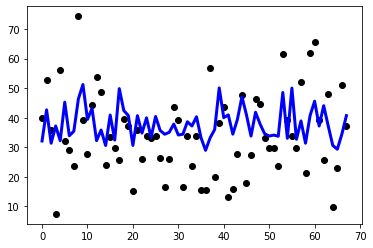

In [14]:
alphas = np.arange(0.1,5,0.1)

model = Ridge()
cv = GridSearchCV(estimator = model,param_grid = dict(alpha = alphas))
y_pred = cv.fit(x_train,y_train).predict(x_test)

plt.scatter(range(len(y_test)),y_test,color = 'black')
plt.plot(y_pred,color = 'blue',linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%lr.intercept_)
print("Coefficients: %s"%str(lr.coef_))

#### lasso Regression

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: 0.114494
Intercept: 40.011990
Coefficients: [ 4.27092993 -2.16623978 -1.1613041   1.81687336 -0.41577903]


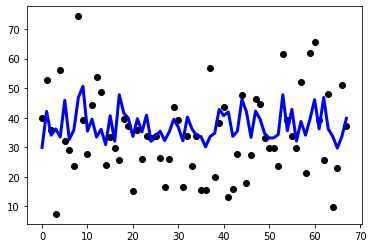

In [15]:
model = Lasso()
cv = GridSearchCV(estimator = model , param_grid = dict(alpha = alphas))

y_pred = cv.fit(x_train,y_train).predict(x_test)
plt.scatter(range(len(y_test)),y_test,color = 'black')
plt.plot(y_pred,color= 'blue',linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%lr.intercept_)
print("Coefficients: %s"%str(lr.coef_))

We see that we have lasso performing better than ridge and linear regression. But R2 is still very low.Lets try ElasticNet(ridge+lasso)

#### ElasticNet

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: 0.104427
Intercept: 40.011990
Coefficients: [ 4.27092993 -2.16623978 -1.1613041   1.81687336 -0.41577903]


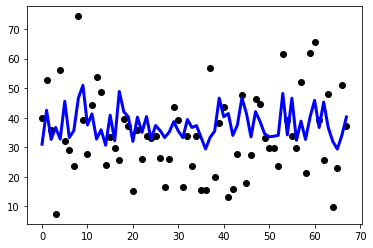

In [16]:
model = ElasticNet()
cv = GridSearchCV(estimator = model,param_grid = dict(alpha = alphas))
y_pred = cv.fit(x_train,y_train).predict(x_test)

plt.scatter(range(len(y_test)),y_test,color = 'black')
plt.plot(y_pred,color= 'blue',linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%lr.intercept_)
print("Coefficients: %s"%str(lr.coef_))

We did not see any improvements , moreover the score decreased.

#### Gradient Boosted Regression

###### Doing Simple Linear regression with GBR

cement_component 0.32374684177355983
fly_ash 0.11903641162952217
water_component 0.33490410706028007
superplasticizer 0.13436843357531314
coarse_agg 0.16611151171465954


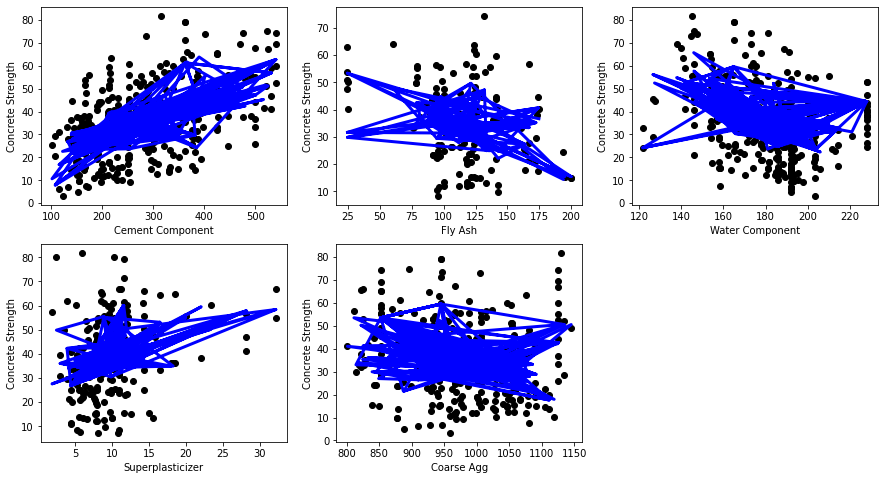

In [17]:
plt.figure(figsize=(15,8))
plot_count = 1

for feature in ['cement_component', 'fly_ash', 'water_component','superplasticizer', 'coarse_agg']:
    data_tr = data[['concrete_strength',feature]]
    data_tr = data_tr[(data_tr.T!=0).all()]
    x_train,y_train,x_test,y_test = split_train_test(data_tr , feature)
    
    gbr = GradientBoostingRegressor()
    gbr.fit(x_train,y_train)
    y_pred = gbr.predict(x_test)
    
    plt.subplot(2,3,plot_count)
    plt.scatter(x_test,y_test,color = 'black')
    plt.plot(x_test,y_pred,color = 'blue',linewidth = 3)
    plt.xlabel(feature.replace("_"," ").title())
    plt.ylabel("Concrete Strength")
    
    print(feature, r2_score(y_test,y_pred))
    
    plot_count += 1
    
plt.show()

Here we see some better r2 score and also observe that cement_component gave the best result of r2_score of 0.32.

###### Doing multiple GBR

In [18]:
learning_rate = [0.001,0.01,0.1]
min_samples_split = [2,4,6,8,10,12]
min_samples_leaf = [2,3,4,5,6,7,8,9,10]

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: -0.193539
Intercept: 40.011990
Coefficients: [ 4.27092993 -2.16623978 -1.1613041   1.81687336 -0.41577903]


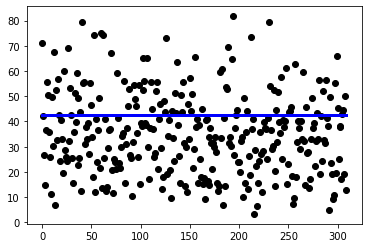

In [19]:
model = GradientBoostingRegressor()
cv = GridSearchCV(estimator = model,param_grid = dict(learning_rate = learning_rate,min_samples_leaf = min_samples_leaf,min_samples_split=min_samples_split))

y_pred = cv.fit(x_train,y_train).predict(y_test)

plt.scatter(range(len(y_test)),y_test,color = 'black')
plt.plot(y_pred,color= 'blue',linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%lr.intercept_)
print("Coefficients: %s"%str(lr.coef_))

This is the worst r2_score till yet and hence GBR is not helping with our extrapolation.

## SVM

cement_component 0.24329990356038123
fly_ash 0.07890320229948367
water_component 0.09319405413251391
superplasticizer 0.06442259735609746
coarse_agg 0.009194561367989018


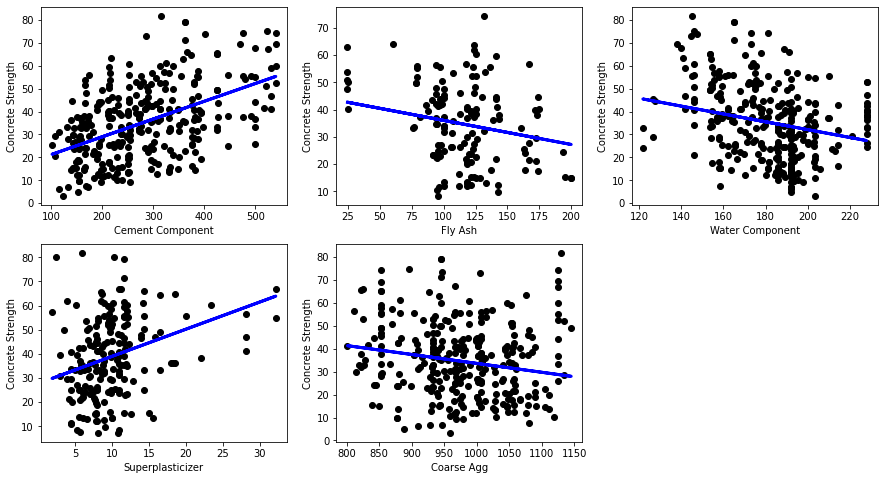

In [20]:
plt.figure(figsize=(15,8))
plot_count = 1

for feature in ['cement_component', 'fly_ash', 'water_component','superplasticizer', 'coarse_agg']:
    data_tr = data[['concrete_strength',feature]]
    data_tr = data_tr[(data_tr.T!=0).all()]
    x_train,y_train,x_test,y_test = split_train_test(data_tr , feature)
    
    svr = SVR(kernel = 'linear')
    svr.fit(x_train,y_train)
    y_pred = svr.predict(x_test)
    
    plt.subplot(2,3,plot_count)
    plt.scatter(x_test,y_test,color = 'black')
    plt.plot(x_test,y_pred,color = 'blue',linewidth = 3)
    plt.xlabel(feature.replace("_"," ").title())
    plt.ylabel("Concrete Strength")
    
    print(feature, r2_score(y_test,y_pred))
    
    plot_count += 1
    
plt.show()

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: 0.010180
Intercept: 72.486508
Coefficients: [[-0.0388676]]


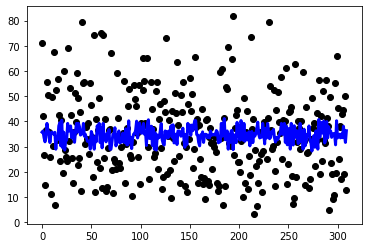

In [21]:
kernels = ["linear","polynomial","sigmoid"]
c = [0.001,0.1,0.2,0.3,0.4,0.5,0.6]
gamma = [0.001,0.1,0.2,0.3,0.4]
model = SVR()
cv = GridSearchCV(estimator = model,param_grid = dict(kernel = kernels,C=c,gamma = gamma))
y_pred = cv.fit(x_train,y_train).predict(x_test)

plt.scatter(range(len(y_test)),y_test,color = 'black')
plt.plot(y_pred,color= 'blue',linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%svr.intercept_)
print("Coefficients: %s"%str(svr.coef_))

We see no improvement in our R2_score.

## Using Random Forest 

cement_component 0.2994533260339326
fly_ash 0.05672091042304672
water_component 0.3008262028081291
superplasticizer 0.06655263646770593
coarse_agg 0.18401615114783498


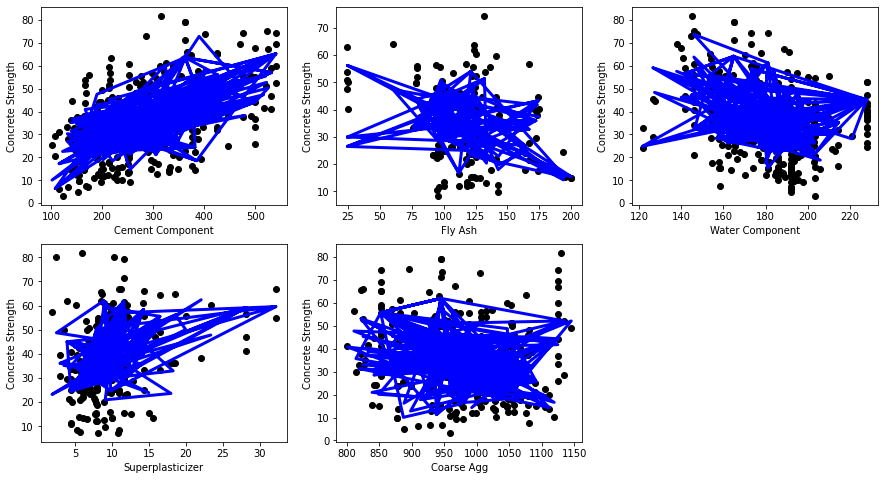

In [22]:
plt.figure(figsize=(15,8))
plot_count = 1

for feature in ['cement_component', 'fly_ash', 'water_component','superplasticizer', 'coarse_agg']:
    data_tr = data[['concrete_strength',feature]]
    data_tr = data_tr[(data_tr.T!=0).all()]
    x_train,y_train,x_test,y_test = split_train_test(data_tr , feature)
    
    rfr = RandomForestRegressor()
    rfr.fit(x_train,y_train)
    y_pred = rfr.predict(x_test)
    
    plt.subplot(2,3,plot_count)
    plt.scatter(x_test,y_test,color = 'black')
    plt.plot(x_test,y_pred,color = 'blue',linewidth = 3)
    plt.xlabel(feature.replace("_"," ").title())
    plt.ylabel("Concrete Strength")
    
    print(feature, r2_score(y_test,y_pred))
    
    plot_count += 1
    
plt.show()

In [23]:
max_depths = [2,4,6,8,10]
min_samples_split = [2,4,6,8,10,12]
min_samples_leaf = [2,3,4,5,6,7,8,9,10]

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: -0.119355
Intercept: 40.011990
Coefficients: [ 4.27092993 -2.16623978 -1.1613041   1.81687336 -0.41577903]


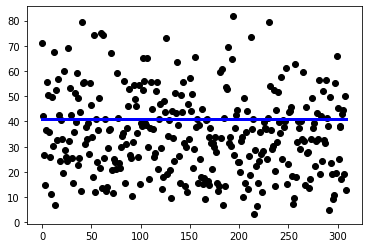

In [24]:
model = RandomForestRegressor()
cv = GridSearchCV(estimator = model,param_grid = dict(max_depth = max_depths,min_samples_leaf = min_samples_leaf,min_samples_split=min_samples_split))

y_pred = cv.fit(x_train,y_train).predict(y_test)

plt.scatter(range(len(y_test)),y_test,color = 'black')
plt.plot(y_pred,color= 'blue',linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%lr.intercept_)
print("Coefficients: %s"%str(lr.coef_))

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_agg']
R2_score: -0.114143
Intercept: 40.011990
Coefficients: [ 4.27092993 -2.16623978 -1.1613041   1.81687336 -0.41577903]


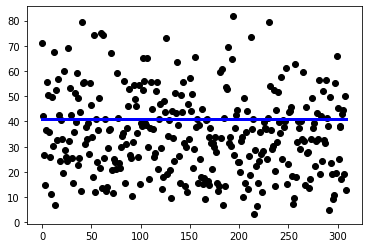

In [25]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()


cv = GridSearchCV(estimator = model,param_grid = dict())

y_pred = model.fit(x_train,y_train).predict(y_test)

plt.scatter(range(len(y_test)),y_test,color = 'black')
plt.plot(y_pred,color= 'blue',linewidth = 3)

print("Features: %s"%str(features))
print("R2_score: %f"%r2_score(y_test,y_pred))
print("Intercept: %f"%lr.intercept_)
print("Coefficients: %s"%str(lr.coef_))

## Final Thoughts
We are getting best results with Single Gradient Boosting Regression trees.

## Interpretation of model

From all the above models we come to know that our most important features were cement_component', 'water-component' &  'coarse-aggregate'. 
Thus we can predict the concrete strength from these variables.

### Predicting concrete strength from Cement Component.
Confidence interval for cement component to predict concrete strength is 34% approx.

In [42]:
feature = ['cement_component','water_component','coarse_agg']
new_data = [120.3,312,1100]
for feature,new_data in zip(feature,new_data):
  print("Feature : %s"%feature)
  print("New data : %f"%new_data)
  data_tr = data[['concrete_strength',feature]]
  data_tr = data_tr[(data_tr.T!=0).all()]

  x_train,y_train,x_test,y_test = split_train_test(data_tr,feature)
  regr = GradientBoostingRegressor()

  ## training the model
  regr.fit(x_train,y_train)
  pred = regr.predict(np.array(new_data).reshape(-1,1))
  print("The predicted value of concrete strength from {} is {}".format(feature,pred))
  print("--------------------------------------------------------------------------------")


Feature : cement_component
New data : 120.300000
The predicted value of concrete strength from cement_component is [22.61132185]
--------------------------------------------------------------------------------
Feature : water_component
New data : 312.000000
The predicted value of concrete strength from water_component is [29.55239704]
--------------------------------------------------------------------------------
Feature : coarse_agg
New data : 1100.000000
The predicted value of concrete strength from coarse_agg is [19.96449128]
--------------------------------------------------------------------------------


# Conclusion
- Although upgrade took place at plant , results are not satifactory, so a testing unit should be implanted in the plant.
- Since we have found out the factors that can predict the concrete strength, these factors should be given at most priority during testing and a threshold value should be set for production of better concrete.